In [ ]:
import kagglehub


path = kagglehub.dataset_download("yidazhang07/bridge-cracks-image")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/bridge-cracks-image


In [ ]:

!pip install kaggle
!pip install tensorflow keras matplotlib scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import files

In [ ]:
data_path = '/kaggle/input/bridge-cracks-image'
img_width, img_height = 224, 224
batch_size = 32
epochs =10

In [ ]:
import os
import matplotlib.pyplot as plt

def explore_data(data_path):

    positive_path = os.path.join(data_path, 'Positive')
    negative_path = os.path.join(data_path, 'Negative')

    if not os.path.exists(positive_path) or not os.path.exists(negative_path):
        print(f"Data structure doesn't match expected format. Exploring actual structure:")
        try:
            print("Top-level directories/files in data_path:")
            print(os.listdir(data_path))
        except FileNotFoundError as e:
            print(f"Provided data_path does not exist: {data_path}")
        return


    positive_images = os.listdir(positive_path)
    negative_images = os.listdir(negative_path)

    print(f"Number of positive examples (with defects): {len(positive_images)}")
    print(f"Number of negative examples (without defects): {len(negative_images)}")


    plt.figure(figsize=(12, 6))


    for i in range(min(3, len(positive_images))):
        img_path = os.path.join(positive_path, positive_images[i])
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title("Defect Sample")
        plt.axis('off')


    for i in range(min(3, len(negative_images))):
        img_path = os.path.join(negative_path, negative_images[i])
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+4)
        plt.imshow(img)
        plt.title("No Defect Sample")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


data_path = "/kaggle/input/bridge-cracks-image"
print("Exploring dataset...")
explore_data(data_path)


Exploring dataset...
Data structure doesn't match expected format. Exploring actual structure:
Top-level directories/files in data_path:
['Bridge_Crack_Image', 'CrackForest', 'Magnetic-Tile-Defect', 'DeepPCB']


In [ ]:
def create_data_generators(data_path):

    print("Directory structure:", os.listdir(data_path))


    train_dir = data_path
    if 'train' in os.listdir(data_path):
        train_dir = os.path.join(data_path, 'train')


    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )


    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )


    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )

    validation_generator = val_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, validation_generator


try:
    train_generator, validation_generator = create_data_generators(data_path)
    print("Class indices:", train_generator.class_indices)
except Exception as e:
    print(f"Error setting up data generators: {e}")
    print("Attempting to fix directory structure...")


    import glob

    all_images = glob.glob(os.path.join(data_path, '**/*.jpg'), recursive=True)
    all_images += glob.glob(os.path.join(data_path, '**/*.png'), recursive=True)


    for i in range(min(5, len(all_images))):
        print(all_images[i])


Directory structure: ['Bridge_Crack_Image', 'CrackForest', 'Magnetic-Tile-Defect', 'DeepPCB']
Found 47356 images belonging to 4 classes.
Found 11838 images belonging to 4 classes.
Class indices: {'Bridge_Crack_Image': 0, 'CrackForest': 1, 'DeepPCB': 2, 'Magnetic-Tile-Defect': 3}


In [ ]:
def create_model():

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_width, img_height, 3)
    )


    base_model.trainable = False


    model = Sequential([
        base_model,


        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])


    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model


model = create_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,028,865 (11.55 MB)

 Trainable params: 770,625 (2.94 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

Epoch 1/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8205 - loss: -2.9523 - precision_1: 0.3968 - recall_1: 0.9902

1479/1479 ━━━━━━━━━━━━━━━━━━━━ 680s 453ms/step - accuracy: 0.8205 - loss: -2.9534 - precision_1: 0.3968 - recall_1: 0.9902 - val_accuracy: 0.9234 - val_loss: -7.9607 - val_precision_1: 0.8665 - val_recall_1: 1.0000
Epoch 2/10
   1/1479 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 0.9375 - loss: -6.8738 - precision_1: 1.0000 - recall_1: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1479/1479 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9375 - loss: -6.8738 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.9236 - val_loss: -7.9855 - val_precision_1: 0.8693 - val_recall_1: 1.0000
Epoch 3/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8792 - loss: -8.4679 - precision_1: 0.5656 - recall_1: 0.9927

1479/1479 ━━━━━━━━━━━━━━━━━━━━ 681s 428ms/step - accuracy: 0.8792 - loss: -8.4687 - precision_1: 0.5656 - recall_1: 0.9927 - val_accuracy: 0.9324 - val_loss: -14.6063 - val_precision_1: 0.9766 - val_recall_1: 0.9964
Epoch 4/10
   1/1479 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step - accuracy: 0.5938 - loss: 3.8556 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

1479/1479 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.5938 - loss: 3.8556 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9325 - val_loss: -14.7414 - val_precision_1: 0.9766 - val_recall_1: 0.9976
Epoch 5/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8838 - loss: -14.3066 - precision_1: 0.5927 - recall_1: 0.9961

1479/1479 ━━━━━━━━━━━━━━━━━━━━ 617s 401ms/step - accuracy: 0.8838 - loss: -14.3073 - precision_1: 0.5927 - recall_1: 0.9961 - val_accuracy: 0.9328 - val_loss: -20.8772 - val_precision_1: 0.9755 - val_recall_1: 1.0000
Epoch 6/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8438 - loss: -34.5714 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.9327 - val_loss: -20.7834 - val_precision_1: 0.9778 - val_recall_1: 1.0000
Epoch 7/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 618s 414ms/step - accuracy: 0.8744 - loss: -20.5251 - precision_1: 0.5610 - recall_1: 0.9942 - val_accuracy: 0.9296 - val_loss: -28.1407 - val_precision_1: 0.9384 - val_recall_1: 1.0000
Epoch 8/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9375 - loss: -35.1000 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.9306 - val_loss: -27.9744 - val_precision_1: 0.9489 - val_recall_1: 1.0000
Epoch 9/10
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 623s 421ms/step - accuracy: 0.8708 - loss: -26.4442 - precisi

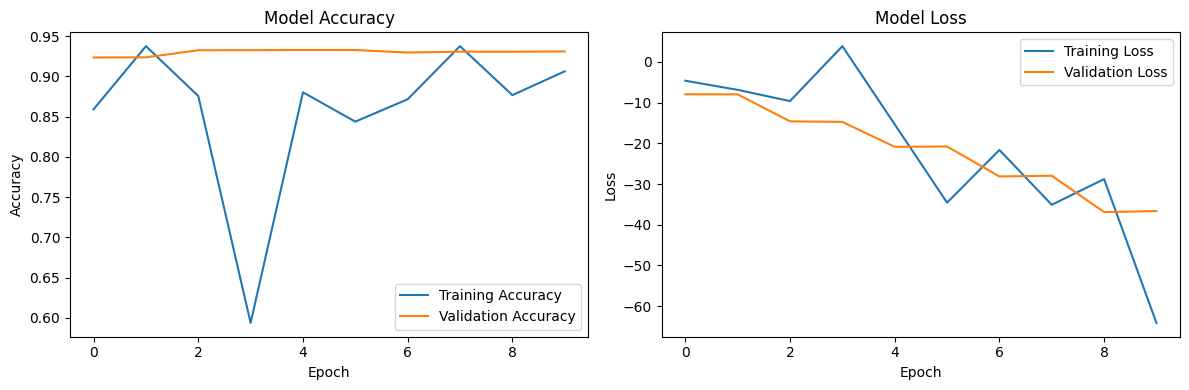

In [ ]:
def train_model(model, train_generator, validation_generator):

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        'best_defect_detection_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )


    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[early_stopping, model_checkpoint]
    )

    return history


try:
    history = train_model(model, train_generator, validation_generator)


    plt.figure(figsize=(12, 4))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error during training: {e}")
    print("Please check the dataset structure and paths.")

In [ ]:
def evaluate_model(model, validation_generator):

    validation_generator.reset()
    y_true = validation_generator.classes


    print("Class indices:", validation_generator.class_indices)
    class_names = list(validation_generator.class_indices.keys())
    print("Detected classes:", class_names)


    predictions = model.predict(validation_generator)

    if len(validation_generator.class_indices) > 2:

        y_pred = np.argmax(predictions, axis=1)
    else:

        y_pred = (predictions > 0.5).astype("int32").flatten()


    y_pred = y_pred[:len(y_true)]


    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def create_model(num_classes):

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_width, img_height, 3)
    )


    base_model.trainable = False


    model = Sequential([
        base_model,


        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])


    loss_function = 'categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=loss_function,
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [ ]:

train_generator, validation_generator = create_data_generators(data_path)


num_classes = len(train_generator.class_indices)
print(f"Detected {num_classes} classes: {train_generator.class_indices}")


model = create_model(num_classes)

Directory structure: ['Bridge_Crack_Image', 'CrackForest', 'Magnetic-Tile-Defect', 'DeepPCB']
Found 47356 images belonging to 4 classes.
Found 11838 images belonging to 4 classes.
Detected 4 classes: {'Bridge_Crack_Image': 0, 'CrackForest': 1, 'DeepPCB': 2, 'Magnetic-Tile-Defect': 3}


In [ ]:

train_generator, validation_generator = create_data_generators(data_path)


num_classes = len(train_generator.class_indices)
print(f"Detected {num_classes} classes: {train_generator.class_indices}")


model = create_model(num_classes)


from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_dir = data_path
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical' if num_classes > 2 else 'binary',
    subset='training')

Directory structure: ['Bridge_Crack_Image', 'CrackForest', 'Magnetic-Tile-Defect', 'DeepPCB']
Found 47356 images belonging to 4 classes.
Found 11838 images belonging to 4 classes.
Detected 4 classes: {'Bridge_Crack_Image': 0, 'CrackForest': 1, 'DeepPCB': 2, 'Magnetic-Tile-Defect': 3}
Found 47356 images belonging to 4 classes.


In [ ]:
model.save('my_model.keras')
print("Model saved as 'my_model.keras'")

Model saved as 'my_model.keras'


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import cv2
from scipy import ndimage
import glob


img_width, img_height = 224, 224
batch_size = 32

def find_images_in_directory(directory=None):
    """Find all image files in the current directory and subdirectories"""
    if directory is None:

        directory = os.getcwd()

    print(f"Searching for images in: {directory}")


    image_paths = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_paths.extend(glob.glob(os.path.join(directory, ext)))
        image_paths.extend(glob.glob(os.path.join(directory, '**', ext), recursive=True))


    image_paths = sorted(list(set(image_paths)))

    if image_paths:
        print(f"Found {len(image_paths)} images. First few images:")
        for i, path in enumerate(image_paths[:5]):
            print(f"  {i+1}. {path}")
    else:
        print("No images found.")

    return image_paths

def non_max_suppression(boxes, overlap_threshold):

    if len(boxes) == 0:
        return []

    if len(boxes) == 1:
        return boxes

    boxes = sorted(boxes, key=lambda x: x[3], reverse=True)

    pick = []

    x1 = np.array([box[0] for box in boxes])
    y1 = np.array([box[1] for box in boxes])
    x2 = np.array([box[0] + box[2] for box in boxes])
    y2 = np.array([box[1] + box[2] for box in boxes])

    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    indices = np.arange(len(boxes))

    while len(indices) > 0:
        i = indices[0]
        pick.append(boxes[i])

        if len(indices) == 1:
            break

        indices = indices[1:]

        xx1 = np.maximum(x1[i], x1[indices])
        yy1 = np.maximum(y1[i], y1[indices])

        xx2 = np.minimum(x2[i], x2[indices])
        yy2 = np.minimum(y2[i], y2[indices])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[indices]

        indices = indices[overlap <= overlap_threshold]

    return pick

def predict_defect(image_path, model):

    try:
        # Check if image exists
        if not os.path.exists(image_path):
            print(f"Error: Image not found at: {image_path}")
            return None

        img = image.load_img(image_path, target_size=(img_width, img_height))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array)[0][0]

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        result = "DEFECT DETECTED" if prediction > 0.5 else "NO DEFECT"
        confidence = prediction if prediction > 0.5 else 1 - prediction
        plt.title(f"{result}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()

        return {
            'result': result,
            'confidence': float(confidence),
            'raw_prediction': float(prediction)
        }
    except Exception as e:
        print(f"Error in predict_defect: {e}")
        return None

def detect_defect_locations(image_path, model, threshold=0.5, window_size=64, stride=32):

    try:

        if not os.path.exists(image_path):
            print(f"Error: Image not found at: {image_path}")
            return None, []

        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image at {image_path}")
            return None, []

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]

        result_img = img_rgb.copy()

        detections = []

        for y in range(0, height - window_size, stride):
            for x in range(0, width - window_size, stride):
                window = img_rgb[y:y + window_size, x:x + window_size]

                window_resized = cv2.resize(window, (img_width, img_height))
                window_array = window_resized / 255.0
                window_array = np.expand_dims(window_array, axis=0)

                prediction = model.predict(window_array, verbose=0)[0][0]

                if prediction > threshold:
                    detections.append((x, y, window_size, prediction))

        final_detections = non_max_suppression(detections, 0.3)

        for (x, y, size, conf) in final_detections:
            cv2.rectangle(result_img,
                         (x, y),
                         (x + size, y + size),
                         (255, 0, 0), 2)

            cv2.putText(result_img,
                       f"{conf:.2f}",
                       (x, y - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                       (255, 0, 0), 2)

        return result_img, final_detections
    except Exception as e:
        print(f"Error in detect_defect_locations: {e}")
        return None, []

def predict_defect_with_localization(image_path, model, confidence_threshold=0.5):

    try:

        if not os.path.exists(image_path):
            print(f"Error: Image not found at: {image_path}")
            print("Available directories:", os.listdir())
            return None


        result_img, detections = detect_defect_locations(
            image_path, model, threshold=confidence_threshold, window_size=64, stride=32
        )

        if result_img is None:
            return None


        img = image.load_img(image_path, target_size=(img_width, img_height))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array, verbose=0)[0][0]

        plt.figure(figsize=(10, 10))
        plt.imshow(result_img)

        result = "DEFECT DETECTED" if prediction > 0.5 else "NO DEFECT"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.title(f"{result}\nConfidence: {confidence:.2f}\nDetected defects: {len(detections)}", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        return {
            'result': result,
            'confidence': float(confidence),
            'raw_prediction': float(prediction),
            'num_defects': len(detections),
            'defect_locations': detections
        }
    except Exception as e:
        print(f"Error in predict_defect_with_localization: {e}")
        return None

def visualize_defect_detection(image_path, model, threshold=0.5):

    try:

        if not os.path.exists(image_path):
            print(f"Error: Image not found at: {image_path}")
            return None


        result_img, blend, heatmap, detections = detect_defects_with_heatmap(
            image_path, model, threshold=threshold
        )

        if result_img is None:
            return None


        img = image.load_img(image_path, target_size=(img_width, img_height))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        prediction = model.predict(img_array, verbose=0)[0][0]


        plt.figure(figsize=(15, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(result_img)
        plt.title("Defect Localization")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(blend)
        plt.title("Defect Probability Heatmap")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(heatmap, cmap='hot')
        plt.colorbar(label='Defect Probability')
        plt.title("Raw Probability Map")
        plt.axis('off')

        result = "DEFECT DETECTED" if prediction > 0.5 else "NO DEFECT"
        confidence = prediction if prediction > 0.5 else 1 - prediction
        plt.suptitle(f"{result} - Confidence: {confidence:.2f} - Defects Found: {len(detections)}", fontsize=16)

        plt.tight_layout()
        plt.show()

        return {
            'result': result,
            'confidence': float(confidence),
            'raw_prediction': float(prediction),
            'num_defects': len(detections),
            'defect_locations': detections
        }
    except Exception as e:
        print(f"Error in visualize_defect_detection: {e}")
        return None

def detect_defects_with_heatmap(image_path, model, threshold=0.5, window_size=64, stride=16):

    try:

        if not os.path.exists(image_path):
            print(f"Error: Image not found at: {image_path}")
            return None, None, None, []

        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image at {image_path}")
            return None, None, None, []

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]

        heatmap = np.zeros((height, width))
        count_map = np.zeros((height, width))

        for y in range(0, height - window_size, stride):
            for x in range(0, width - window_size, stride):
                window = img_rgb[y:y + window_size, x:x + window_size]

                window_resized = cv2.resize(window, (img_width, img_height))
                window_array = window_resized / 255.0
                window_array = np.expand_dims(window_array, axis=0)

                prediction = model.predict(window_array, verbose=0)[0][0]

                heatmap[y:y + window_size, x:x + window_size] += prediction
                count_map[y:y + window_size, x:x + window_size] += 1

        count_map = np.where(count_map == 0, 1, count_map)
        heatmap = heatmap / count_map

        heatmap = ndimage.gaussian_filter(heatmap, sigma=2)

        binary_map = heatmap > threshold
        binary_map = binary_map.astype(np.uint8) * 255
        contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        result_img = img_rgb.copy()

        detections = []
        for contour in contours:
            if cv2.contourArea(contour) < 100:
                continue

            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(result_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

            region_confidence = np.mean(heatmap[y:y+h, x:x+w])
            cv2.putText(result_img,
                      f"{region_confidence:.2f}",
                      (x, y - 5),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      (255, 0, 0), 2)

            detections.append((x, y, w, h, region_confidence))

        heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        alpha = 0.7
        blend = cv2.addWeighted(img_rgb, alpha, heatmap_colored, 1-alpha, 0)

        return result_img, blend, heatmap, detections
    except Exception as e:
        print(f"Error in detect_defects_with_heatmap: {e}")
        return None, None, None, []


def run_defect_detection(model_path=None):

    try:

        if model_path and not os.path.exists(model_path):
            print(f"Error: Model not found at: {model_path}")
            return


        if model_path:
            print(f"Loading model from: {model_path}")
            model = load_model(model_path)
        else:
            print("No model path specified. Please provide a valid model path.")
            return


        images = find_images_in_directory()

        if not images:
            print("No images found to analyze.")
            return


        if len(images) > 0:
            selected_image = images[0]
            print(f"\nAnalyzing image: {selected_image}")


            result = predict_defect_with_localization(selected_image, model)

            if result:
                print("\nResults:")
                print(f"- Overall result: {result['result']}")
                print(f"- Confidence: {result['confidence']:.2f}")
                print(f"- Number of defects detected: {result['num_defects']}")


                print("\nGenerating detailed visualization with heatmap...")
                visualize_defect_detection(selected_image, model)
            else:
                print("Could not analyze the image.")
        else:
            print("No images available for analysis.")

    except Exception as e:
        print(f"Error in run_defect_detection: {e}")


sample testing

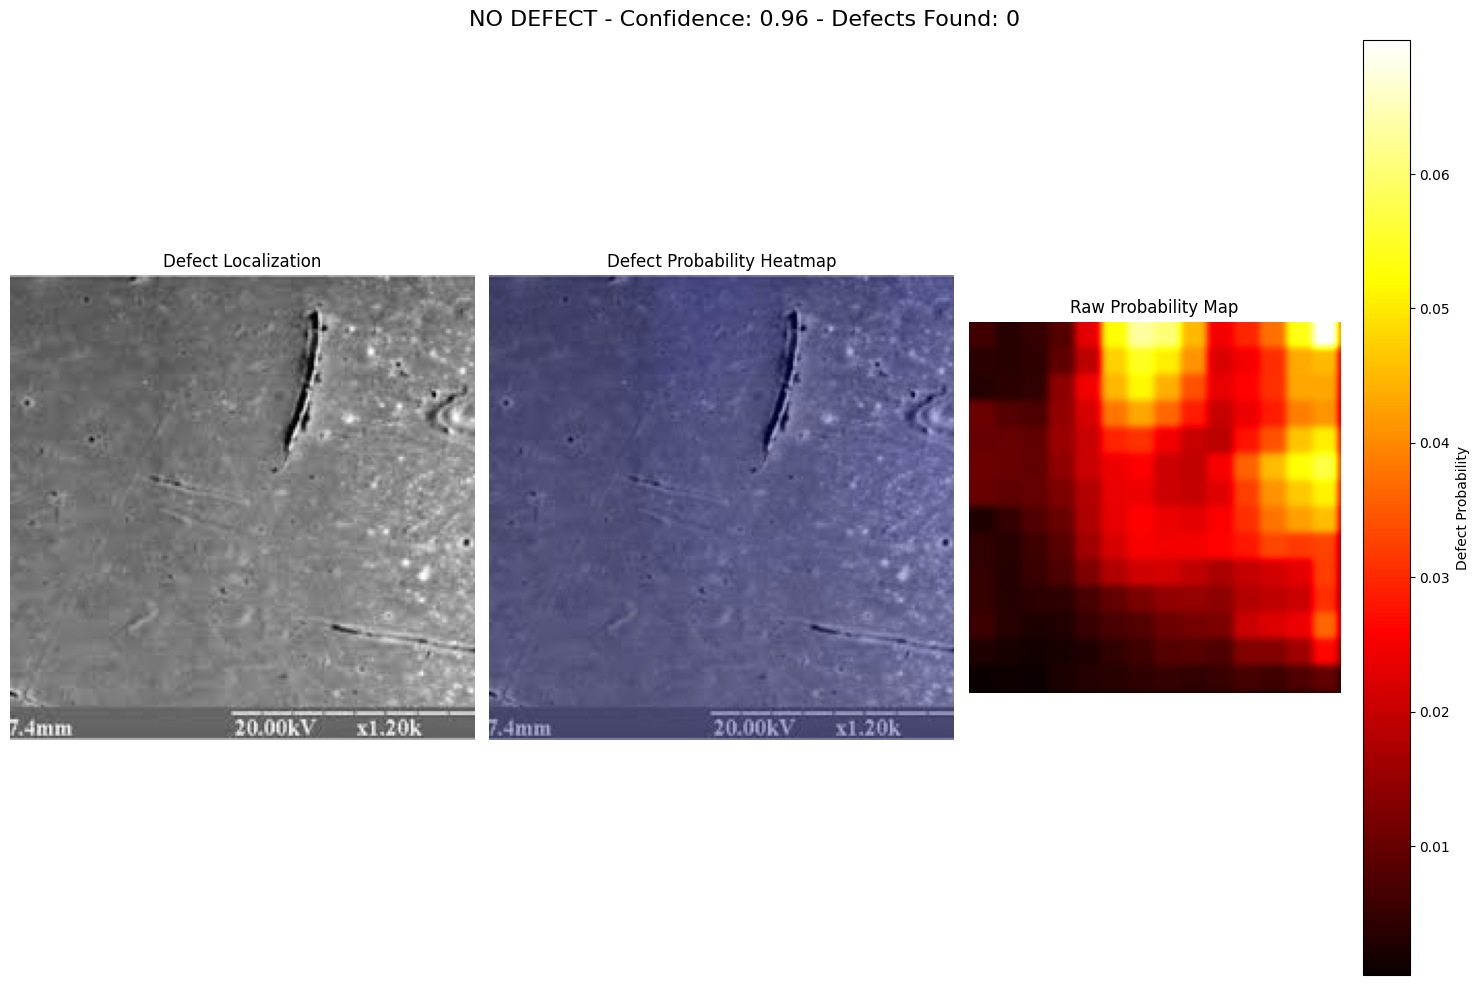

In [ ]:
result = visualize_defect_detection('/content/images.jpg', model, threshold=0.4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


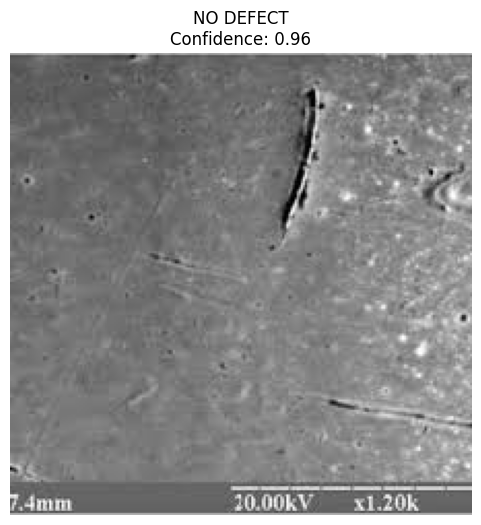

Prediction result: {'result': 'NO DEFECT', 'confidence': 0.9610862731933594, 'raw_prediction': 0.038913704454898834}


In [ ]:
test_image_path = '/content/images.jpg'
result = predict_defect(test_image_path, model)
print(f"Prediction result: {result}")

In [ ]:

def process_folder(folder_path, model):
    import glob


    image_extensions = ['*.jpg', '*.jpeg', '*.png']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, ext)))

    results = []


    for img_path in image_files:
        print(f"Processing: {os.path.basename(img_path)}")
        result = predict_defect(img_path, model)
        result['filename'] = os.path.basename(img_path)
        results.append(result)


    results_df = pd.DataFrame(results)
    print("\nSummary of results:")
    print(results_df)


    defect_count = sum(1 for r in results if r['result'] == 'DEFECT DETECTED')
    print(f"\nFound {defect_count} images with defects out of {len(results)} images.")

    return results_df